# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?

*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться...

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [ ]:
pip install https://github.com/rsennrich/subword-nmt/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 133.6 kB 4.5 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for subword-nmt: filename=subword_nmt-0.3.8-py3-none-any.whl size=27417 sha256=f2c1f414c065366347e2c088ec8136ced16757d3f81168acbe92a4cc3434dc94
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ctk_q_k/wheels/ad/80/61/228c4158a6afae4c49fd10746abe1e625bb3341ab8ab3be403
Successfully built subword-nmt


In [ ]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('/content/data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:10<00:00, 781.34it/s] 


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [ ]:
import numpy as np

In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [ ]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


## За вас сделали домашнюю работу? Нет, вам самое интересное!

Если вы пролистываете ноутбук и вам уже очень хочется начать писать самим - то мы вас понимаем, задание очень интересное и полезное!
И спешим вас обрадовать, так как вы дождались и тут как раз можно проявить всю фантазию и мастерство написание нейронных сетей!


###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

Заполните пропуски с `<YOUR CODE HERE>`

In [ ]:
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(55)

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и
        логиты для следующих токенов
        """

        x = self.emb_out(prev_tokens)
        prev_gru0_state = prev_state[0]
        new_dec_state = self.dec0(x, prev_gru0_state)
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state

        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
even@@ alta penh diamond weingut ska madison access areas üh@@ part hammock holidays holidays dallas kav@@ driving sell@@ tur@@ ites en eta crown leave stro@@
ading buses ais intern@@ slope also express cel@@ bistro 59 rol@@ atory gale@@ vet@@ lom@@ cush@@ botan@@ pensi@@ fre@@ fishing décor explo@@ atory gale@@ vet@@
ading buses ais intern@@ slope swimming ener@@ del@@ porto@@ asturi@@ smolen@@ taksim choices exercise ghur@@ noo@@ ered tory й hat@@ church 59 rol@@ atory metyevo


### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг

In [ ]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)
    # log-probabilities всех токеноы на всех шагах
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1) # [batch_size, out_len, num_tokens]

    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]
    # нужно обойтись только векторными операциями без for

    # cross-entropy по всем токенам где mask == True
    return -logp_out[mask].mean() # тут должен получиться скаляр!

In [ ]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.4860, device='cuda:0', grad_fn=<NegBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход,
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.002115108453012893

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

def train_model(model, n_iter, batch_size, optimizer, metrics):
  with tqdm(range(n_iter)) as progress_bar:
        for i in progress_bar:
            model.train()
            # step = len(metrics['train_loss']) + 1
            batch_ix = np.random.randint(len(train_inp), size=batch_size)
            batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
            batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

            optimizer.zero_grad()
            loss_t = loss_function(model, batch_inp, batch_out)
            loss_t.backward()
            optimizer.step()

            metrics['train_loss'].append((i, loss_t.item()))

            if i % 100 == 0:
                model.eval()
                bleu = compute_bleu(model, dev_inp, dev_out)
                metrics['dev_bleu'].append((i, bleu))
                clear_output(wait=True)
                plt.figure(figsize=(9, 3))
                for i, (name, history) in enumerate(sorted(metrics.items())):
                    plt.subplot(1, len(metrics), i + 1)
                    plt.title(name)
                    plt.plot(*zip(*history))
                    plt.grid()
                plt.show()

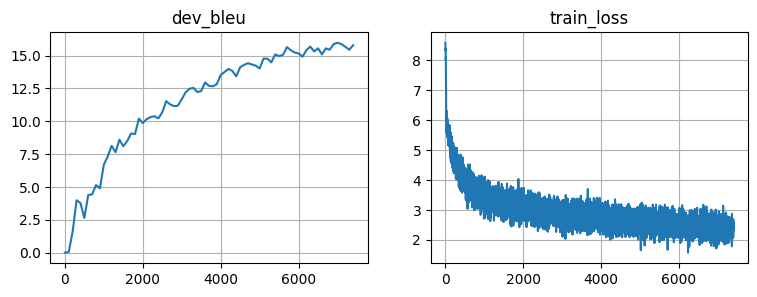

100%|██████████| 7500/7500 [05:31<00:00, 22.60it/s]


In [ ]:
seed_everything(55)
model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'dev_bleu': [] }
batch_size = 32
num_iter = 7500

train_model(model, n_iter=num_iter, batch_size=batch_size, optimizer=opt, metrics=metrics)

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "Ты можешь больше! попробуй еще раз)"

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
parking and free parking are available at the property .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
lake garda is 6 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
offering a restaurant , a garden and a restaurant , hotel villa is a 10 - minute walk from the beach and a garden with a sun terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in rome , this apartment features a bar and a private balcony .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the private bathroom comes with a shower and a hairdryer .



## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов:
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size, act_func=torch.tanh):

        super().__init__()

        self.enc_size = enc_size
        self.dec_size = dec_size
        self.hid_size = hid_size

        self.activation = act_func
        self.linear_e = nn.Linear(enc_size, hid_size)
        self.linear_d = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.soft = nn.Softmax(dim=-1)


    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """

        # считаем логиты
        batch_size, n_inp, enc_size = enc.shape

        out_enc = self.linear_e(enc)
        out_dec = self.linear_d(dec).reshape(-1, 1, self.hid_size)

        logits = self.linear_out(self.activation(out_enc + out_dec))

        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        logits[torch.where(inp_mask == 0)] = -1e9

        # Примените softmax
        probs = self.soft(logits.reshape(batch_size, n_inp))

        # Подсчитайте выход attention используя enc состояния и вероятностями
        attn = (probs.reshape(batch_size, n_inp, 1) * enc).sum(axis=1)

        return attn, probs

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [ ]:
class AttentiveModel(BaseModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):

        """Переводчик с Attention"""
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attn = AttentionLayer(hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """
        # делаем encode
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        [dec_start] = super().encode(inp, **flags)
        enc_mask = self.out_voc.compute_mask(inp)

        # применяем attention слой для скрытых состояний
        first_attn_probas = self.attn(enc_seq, dec_start, enc_mask)[1]

        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention

        first_state = [dec_start, enc_seq, enc_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_prob = self.attn(enc_seq, prev_gru0_state, enc_mask)

        out = self.emb_out(prev_tokens)
        out = torch.cat([attn, out], dim=-1)
        out = self.dec0(out, prev_gru0_state)

        new_dec_state = [out, enc_seq, enc_mask, attn_prob]
        output_logits = self.logits(out)
        return [new_dec_state, output_logits]

### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

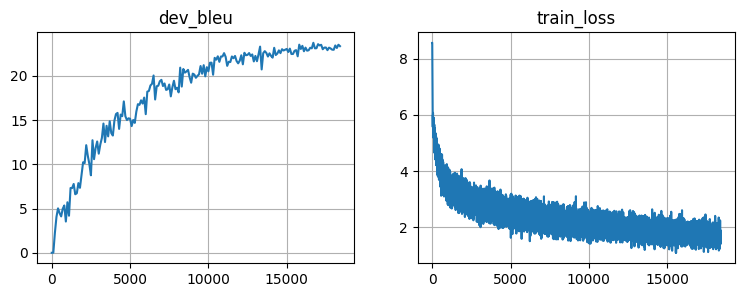

100%|██████████| 18500/18500 [37:45<00:00,  8.17it/s]


In [ ]:
seed_everything(55)
attentive_model = AttentiveModel(inp_voc=inp_voc, out_voc = out_voc).to(device)
att_metrics = {'train_loss': [], 'dev_bleu': [] }
att_opt = torch.optim.Adam(attentive_model.parameters(), lr=1e-3)
att_num_iter = 18500
att_batch_size = 32

train_model(attentive_model, n_iter=att_num_iter, batch_size=att_batch_size, optimizer=att_opt, metrics=att_metrics)

In [ ]:
assert np.mean(att_metrics['dev_bleu'][-10:], axis=0)[1] > 23, "Ты можешь больше! попробуй еще раз)"

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], attentive_model.translate_lines(dev_inp[:500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests can relax in the common kitchen and shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
at cabañas los volcan@@ e you will find a garden and a terrace .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the property is located just 6 metres from the a8 motorway line railway station and the city centre of the city centre .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
free wi - fi is available in public areas .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
the hotel is a short walk from the centre of the centre of the city centre and the town centre .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the friendly staff can help provide sightseeing and help for

## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)

Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

In [ ]:
! pip install datasets transformers[sentencepiece] sacrebleu
! apt install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
hugging_model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=hugging_model)

/usr/local/lib/python3.9/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
from torch.utils.data import Dataset
class DatasetForHelsinki(Dataset):
    def __init__(self, inputs, outputs, labels):
        self.inputs = inputs
        self.outputs = outputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        inp = self.inputs[idx]
        out = self.outputs[idx]
        label = self.labels[idx]
        att_mask = tokenizer(inp, text_target=out,
                                            max_length=128, truncation=True)
        sample = {"input_ids": att_mask["input_ids"],
                  "attention_mask": att_mask["attention_mask"],
                  "labels": att_mask["labels"]}
        return sample

train_dataset = DatasetForHelsinki(train_inp, train_out, [0]*len(train_inp))
test_dataset = DatasetForHelsinki(dev_inp, dev_out, [0]*len(dev_inp))

In [ ]:
from datasets import  load_metric

metric = load_metric("sacrebleu")
hugging_metrics = {'dev_bleu': []}

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    hugging_metrics['dev_bleu'].append(result["score"])
    result = {"bleu": result["score"]}

    return result

<ipython-input-28-1a38fc68ad43>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

source_lang = "ru"
target_lang = "en"

batch_size = 32
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    hugging_model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

Cloning https://huggingface.co/akardashova/opus-mt-ru-en-finetuned-ru-to-en into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/291M [00:00<?, ?B/s]

Download file runs/Apr26_21-15-31_5505b0f82900/1682543737.3991208/events.out.tfevents.1682543737.5505b0f82900.…

Download file runs/Apr26_20-56-06_5505b0f82900/1682542638.965957/events.out.tfevents.1682542638.5505b0f82900.5…

Download file runs/Apr26_21-31-28_5505b0f82900/1682544693.2702441/events.out.tfevents.1682544693.5505b0f82900.…

Download file runs/Apr26_18-56-25_a4bd3f2b1c60/1682535389.64926/events.out.tfevents.1682535389.a4bd3f2b1c60.47…

Clean file runs/Apr26_21-15-31_5505b0f82900/1682543737.3991208/events.out.tfevents.1682543737.5505b0f82900.566…

Clean file runs/Apr26_20-56-06_5505b0f82900/1682542638.965957/events.out.tfevents.1682542638.5505b0f82900.566.…

Clean file runs/Apr26_21-31-28_5505b0f82900/1682544693.2702441/events.out.tfevents.1682544693.5505b0f82900.566…

Download file target.spm:   1%|1         | 8.00k/784k [00:00<?, ?B/s]

Download file runs/Apr26_21-05-55_5505b0f82900/1682543160.4955726/events.out.tfevents.1682543160.5505b0f82900.…

Clean file runs/Apr26_18-56-25_a4bd3f2b1c60/1682535389.64926/events.out.tfevents.1682535389.a4bd3f2b1c60.47524…

Clean file runs/Apr26_21-05-55_5505b0f82900/1682543160.4955726/events.out.tfevents.1682543160.5505b0f82900.566…

Download file source.spm:   0%|          | 1.40k/1.03M [00:00<?, ?B/s]

Download file runs/Apr26_18-55-56_a4bd3f2b1c60/1682535365.1626766/events.out.tfevents.1682535365.a4bd3f2b1c60.…

Clean file runs/Apr26_18-55-56_a4bd3f2b1c60/1682535365.1626766/events.out.tfevents.1682535365.a4bd3f2b1c60.475…

Download file runs/Apr26_21-05-55_5505b0f82900/events.out.tfevents.1682543160.5505b0f82900.566.2: 100%|#######…

Clean file runs/Apr26_21-05-55_5505b0f82900/events.out.tfevents.1682543160.5505b0f82900.566.2:  17%|#7        …

Download file runs/Apr26_21-15-31_5505b0f82900/events.out.tfevents.1682543737.5505b0f82900.566.4: 100%|#######…

Download file runs/Apr26_20-56-06_5505b0f82900/events.out.tfevents.1682542638.5505b0f82900.566.0: 100%|#######…

Clean file runs/Apr26_21-15-31_5505b0f82900/events.out.tfevents.1682543737.5505b0f82900.566.4:  17%|#7        …

Download file runs/Apr26_21-31-28_5505b0f82900/events.out.tfevents.1682544693.5505b0f82900.566.6: 100%|#######…

Clean file runs/Apr26_20-56-06_5505b0f82900/events.out.tfevents.1682542638.5505b0f82900.566.0:  17%|#7        …

Clean file runs/Apr26_21-31-28_5505b0f82900/events.out.tfevents.1682544693.5505b0f82900.566.6:  20%|#9        …

Clean file target.spm:   0%|          | 1.00k/784k [00:00<?, ?B/s]

Clean file source.spm:   0%|          | 1.00k/1.03M [00:00<?, ?B/s]

Download file runs/Apr26_18-56-25_a4bd3f2b1c60/events.out.tfevents.1682535389.a4bd3f2b1c60.47524.2: 100%|#####…

Clean file runs/Apr26_18-56-25_a4bd3f2b1c60/events.out.tfevents.1682535389.a4bd3f2b1c60.47524.2:  20%|#9      …

Download file training_args.bin: 100%|##########| 3.68k/3.68k [00:00<?, ?B/s]

Clean file training_args.bin:  27%|##7       | 1.00k/3.68k [00:00<?, ?B/s]

Download file runs/Apr26_18-55-56_a4bd3f2b1c60/events.out.tfevents.1682535365.a4bd3f2b1c60.47524.0: 100%|#####…

Clean file runs/Apr26_18-55-56_a4bd3f2b1c60/events.out.tfevents.1682535365.a4bd3f2b1c60.47524.0:  21%|##      …

Clean file pytorch_model.bin:   0%|          | 1.00k/291M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu
1,1.428600,1.225266,33.934041


TrainOutput(global_step=1469, training_loss=1.5505508620208261, metrics={'train_runtime': 593.1272, 'train_samples_per_second': 79.243, 'train_steps_per_second': 2.477, 'total_flos': 1256455078281216.0, 'train_loss': 1.5505508620208261, 'epoch': 1.0})

In [ ]:
hugging_metrics['dev_bleu']

[33.93404054689055]

In [ ]:
assert np.mean(hugging_metrics['dev_bleu'], axis=0) > 27, "Ты можешь больше! попробуй еще раз)"